# Forecast Price Model

This notebook is designed to forecast energy prices using the `ForecastPriceModel` class. 
The model is trained on historical data from 2018 and then used to predict prices for a specific date. 
The actual prices for that date are then compared with the forecasted prices.


In [1]:
# Import necessary libraries
from datetime import datetime
import os
import sys
import matplotlib.pyplot as plt

# Set up module path
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import project-specific libraries
from scripts.prices import ForecastPriceModel
from scripts.shared import CSVDataProvider
from scripts.forecast import FeatureEngineer, XGBModel

IMAGE_SAVING_LOCATION = os.path.join(module_path, 'images','notebook','prices')
MODEL_LOCATION = os.path.join(module_path, 'models','prices')

In [2]:
# Load and prepare data
csv_file_path = os.path.join(module_path, "data", "time_series", "time_series_60min_singleindex_filtered.csv")
data_provider = CSVDataProvider(csv_file_path)
data = data_provider.get_data(column_names=["GB_GBN_price_day_ahead"],timestamp_column="utc_timestamp")

# Initialize feature engineer
feature_engineer = FeatureEngineer()

# Load Model
params = {'random_state': 42, "n_estimators": 1000, "max_depth": 6, "learning_rate": 0.1, "objective": "reg:squarederror"}
model=XGBModel(params)

# Train the forecast model
forecaster = ForecastPriceModel(data_provider=data_provider, feature_engineer=feature_engineer, model=model)
train_data = data[data.index.year.isin([2016, 2017, 2018])]
train_data["GB_GBN_price_day_ahead"].interpolate(method="linear", inplace=True)
print(train_data.isna().sum())
forecaster.train(train_data)

c:\Users\koula\Documents\GitHub\OpenEnergy\scripts\prices\forecasted_price.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.data[self.PRICE_COLUMN].interpolate(method="linear", inplace=True)
C:\Users\koula\AppData\Local\Temp\ipykernel_22100\2484807568.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

GB_GBN_price_day_ahead    0
dtype: int64


  0%|          | 0/24 [00:00<?, ?it/s]

[0]	validation_0-rmse:26.79616


c:\Users\koula\miniconda3\envs\OpenEnergy\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:15.46501
[200]	validation_0-rmse:15.40064
[300]	validation_0-rmse:15.39170
[400]	validation_0-rmse:15.38564
[500]	validation_0-rmse:15.37405
[600]	validation_0-rmse:15.36796
[693]	validation_0-rmse:15.37240
[0]	validation_0-rmse:24.62008
[100]	validation_0-rmse:16.91650
[200]	validation_0-rmse:16.82325
[300]	validation_0-rmse:16.82332
[400]	validation_0-rmse:16.80177
[500]	validation_0-rmse:16.78366
[600]	validation_0-rmse:16.78419
[643]	validation_0-rmse:16.78700
[0]	validation_0-rmse:25.62348
[100]	validation_0-rmse:17.53434
[200]	validation_0-rmse:17.37509
[300]	validation_0-rmse:17.31795
[400]	validation_0-rmse:17.30344
[500]	validation_0-rmse:17.29893
[600]	validation_0-rmse:17.28526
[691]	validation_0-rmse:17.28270
[0]	validation_0-rmse:23.53320
[100]	validation_0-rmse:16.31392
[200]	validation_0-rmse:16.16766
[300]	validation_0-rmse:16.13270
[400]	validation_0-rmse:16.10588
[500]	validation_0-rmse:16.07751
[600]	validation_0-rmse:16.06767
[700]	validation

In [3]:
# Save the model
MODEL_NAME = "price_forecast_model.pkl"
forecaster.save_model(os.path.join(MODEL_LOCATION, MODEL_NAME))

In [4]:
# Load the model
model = ForecastPriceModel.load_model(os.path.join(MODEL_LOCATION, MODEL_NAME))
pretrained_forecaster = ForecastPriceModel(data_provider=data_provider, feature_engineer=feature_engineer, model=model)

c:\Users\koula\Documents\GitHub\OpenEnergy\scripts\prices\forecasted_price.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.data[self.PRICE_COLUMN].interpolate(method="linear", inplace=True)


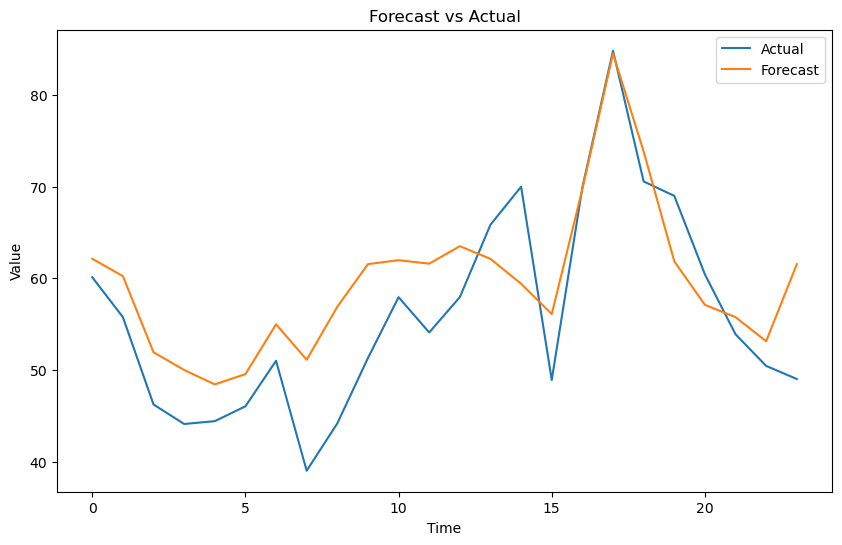

In [5]:
# Get forecasted prices
forecasted_prices, prices_current_date = pretrained_forecaster.get_prices(datetime(2019, 1, 1))

# Plot the actual values and the forecast
plt.figure(figsize=(10, 6))
plt.plot(prices_current_date, label='Actual')
plt.plot(forecasted_prices, label='Forecast')
plt.title('Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.savefig(os.path.join(IMAGE_SAVING_LOCATION, 'forecast_vs_actual.png'))
plt.show()